In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# Auto-Encoder(=A.E.)
* 사용할 데이터 MNIST
* 사용할 모델 : 기본적인 A.E.
> - fc-layer로만 구성된 모델
> - conv-layer로만 구성된 모델
* 학습 후
> - manifold-learning
> - generative-model

## MNIST

### 데이터 전처리 및 사전 작업

In [108]:
# 전처리 transform 정의

mnist_transform = transforms.Compose([transforms.ToTensor(), # PIL Image -> Tensor
                                      transforms.Normalize(mean=(0.5,), std=(1.0,))]) # 정규화

In [109]:
# MNSIT 데이터 다운로드 및 전처리 transform 적용

trainset = datasets.MNIST(root='/content', # 이곳에 MNIST폴더안에 데이터가 저장된다.
                          train=True, download=True,
                          transform=mnist_transform) # 어떤 transform을 할 것인가

testset = datasets.MNIST(root='/content',
                         train=False, download=True,
                         transform=mnist_transform)

In [110]:
# batch 만큼 나눠서 담기; mini-batch GD를 위함

train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

test_loader = DataLoader(trainset, batch_size=8, shuffle=False, num_workers=2) # test임으로 shuffle=False

# 추가 정보
# batch_size=8 : 데이터를 8개씩 가져온다.
# shuffle=True : 랜덤하게 섞는다.
# num_workers=2 : parallel하게 동작할 수 있도록 한다.

In [111]:
# 다음 함수를 통해 DataLoader()안의 값을 확인할 수 있다.

dataiter = iter(train_loader) # 1개만 확인해보자
images, labels = next(dataiter) # A.E.는 unsupervised-learning임으로 사실 labels값은 필요가 없다.
images.shape, labels.shape # tensor의 형태이다.

# 추가 정보
# 사진의 크기 28x28, 흑백(1), 사진 갯수 8개
# label 갯수 8개

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

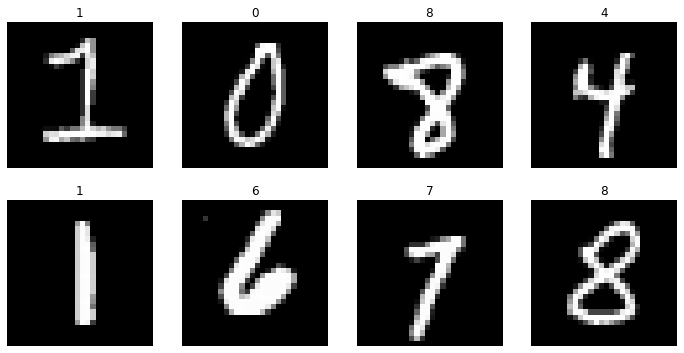

In [112]:
# MINST 데이터 시각화; batch_size인 8개만 꺼내서 확인해보자

figure = plt.figure(figsize=(12,6))
cols, rows = 4, 2
for i in range(1, cols * rows + 1): # 8개를 2행,4열로
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    # random으로 1~60,000개의 데이터 중에 하나를 선택한다.

    img, label = trainset[sample_idx] # trainset의 하나를 랜덤으로 선택해서, img랑 label로 둔다.
    figure.add_subplot(rows, cols, i) # 어떤 영역에 그릴지 선택한다.
    plt.title(label) # 제목은 label로
    plt.axis('off') # 축이름은 없앤다.
    plt.imshow(img.squeeze(), cmap='gray') # img의 흑백차원을 없애고, 회색으로 시각화를 한다.
plt.show()

## 기본적인 A.E. 모델 학습 및 평가

#### 1. fc-layer만을 이용한 A.E.
* AE_Linear

In [153]:
# fc-layer만을 이용한 A.E. 모델 클래스 선언

# 즉, Convolution-layer를 사용하지 않는다.

class AE_Linear(nn.Module):

    # 1. 변수선언
    def __init__(self):
        super(AE_Linear, self).__init__()

################################################################
        # Encoder와 Decoder를 정의할 때,
        # Sequential() : layer를 하나하나 정의하지 않고, 묶어서 정의한다.
################################################################

        # Encoder Neural-Net 부분
        # encoder 변수에 다음 layer들을 쌓아서 완성시킨다.
        self.encoder = nn.Sequential(

            nn.Linear(28 * 28, 128), # (batch-size=8, 784) -> (8, 128)
            nn.ReLU(), # acf로 relu사용
            nn.Linear(128, 64), # (8, 128) -> (8, 64)
            nn.ReLU(),
            nn.Linear(64, 12), # (8, 64) -> (8, 12)
            nn.ReLU(),
            nn.Linear(12, 3) # (8, 12) -> (8, 3) # 3길이의 latent-vector

        )

        # Decoder Neural-Net 부분
        # decoder 변수에 다음 layer들을 쌓아서 완성시킨다.
        self.decoder = nn.Sequential(
            
            # Encoder의 input과 output 노드의 수를 바꿔준다.
            nn.Linear(3, 12), # (8, 3) -> (8, 12)
            nn.ReLU(), # acf도 encoder와 같이 relu사용
            nn.Linear(12, 64), # (8, 12) -> (8, 64)
            nn.ReLU(),
            nn.Linear(64, 128), # (8, 64) -> (8, 128)
            nn.ReLU(),
            nn.Linear(128, 28 * 28), # (8, 128) -> (8, 784)
            nn.Sigmoid()
        )

    # 2. 함수선언
    def forward(self, x): # input값인 x를 encoder와 decoder에 차례로 통과시켜서 A.E.구조를 만든다.
        encoded = self.encoder(x) # encoder 통과
        decoded = self.decoder(encoded) # encoder 통과한 것을 decoder에 통과
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [150]:
# 모델 객체 선언

model_Linear = AE_Linear().to(device) # gpu에 모델 업로드

In [151]:
# 손실함수와 옵티마이저

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_Linear.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5) # 가중치들의 합을 규제하여, 과적합을 막는다.

In [169]:
# 모델 학습; train데이터 이용
# 이전과 달리 unsupervised이나, input-data가 label로 작용하기에
# 기존의 0~9의 labels이 아닌 input-data(28x28 image)를 label로 사용해야한다.

num_epochs = 4
output_list = []

# epoch 마다
for epoch in range(num_epochs):
    # batch 마다
    for i, data in enumerate(train_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        X = images.view(images.shape[0], -1) # Linear적용전에 flatten을 해준다.
        outputs = model_Linear(X) # y_pred = f(X)
        X_hat = outputs
        loss = criterion(X_hat, X)

        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    output_list.append((epoch, X.reshape(-1, 28,28), X_hat.reshape(-1, 28,28)))

Epoch:1, Loss:0.2279
Epoch:2, Loss:0.2273
Epoch:3, Loss:0.2275
Epoch:4, Loss:0.2349


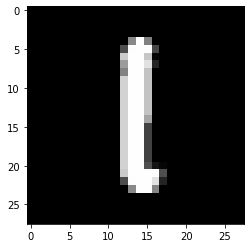

In [178]:
# input-data; X

npimg = X[0].reshape(-1, 28,28).detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0))) # (C,H,W) -> (H,W,C)로 바꿔주는 작업
plt.show()

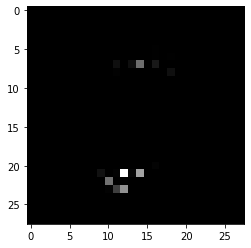

In [179]:
# output-data; X_hat

npimg = X_hat[0].reshape(-1, 28,28).detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

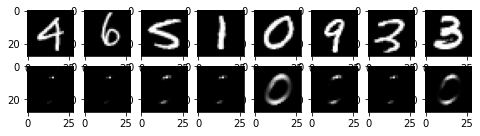

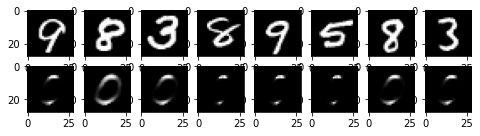

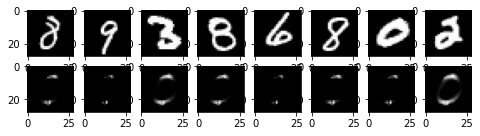

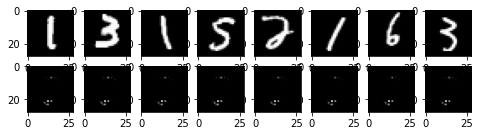

In [180]:
# train데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        item = item.reshape(-1, 28,28) # (28,28) -> (28x28)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1)
        item = item.reshape(-1, 28,28) # (28,28) -> (28x28)
        plt.imshow(item[0])

In [184]:
# 모델 평가; test데이터 이용

correct = 0
output_list = []

with torch.no_grad(): # grad가 필요없다.
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        X = images.view(images.shape[0], -1) # Linear적용전에 flatten을 해준다.
        outputs = model_Linear(X) # y_pred = f(X)
        X_hat = outputs

        output_list.append((epoch, X.reshape(-1, 28,28), X_hat.reshape(-1, 28,28)))

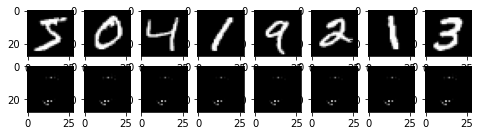

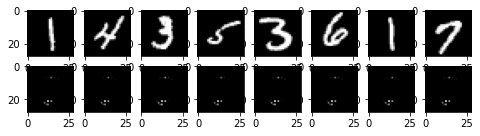

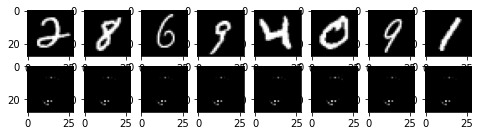

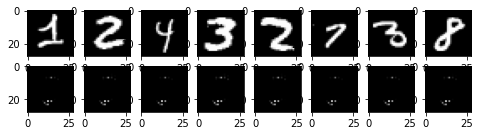

In [185]:
# test데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        item = item.reshape(-1, 28,28) # (28,28) -> (28x28)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1)
        item = item.reshape(-1, 28,28) # (28,28) -> (28x28)
        plt.imshow(item[0])

#### 2. Convolution-layer만을 이용한 A.E.
* AE_Conv

In [214]:
# Convolution-layer만을 이용한 A.E. 모델 클래스 선언

# 즉, fc-layer를 사용하지 않는다.

class AE_Conv(nn.Module):

    # 1. 변수선언
    def __init__(self):
        super(AE_Conv, self).__init__()

        # 1-1. Encoder Neural-Net 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # (8, 1, 28, 28) -> (8, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (8, 16, 14, 14) -> (8, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # (8, 32, 7, 7) -> (8, 64, 1, 1) # 64길이의 latent-vector
        )
        
        # 1-2. Decoder Neural-Net 부분;
        self.decoder = nn.Sequential(
            # ConvTranspose2d() 작동방식 : https://cumulu-s.tistory.com/29
            nn.ConvTranspose2d(64, 32, 7), # (8, 64, 1, 1) -> (8, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (8, 32, 7, 7) -> (8, 16, 14, 14); (8,16,13,13 if without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # (8, 16, 14, 14) -> (8, 1, 28, 28) # encoder의 input-data size와 같아졌다.
            nn.Sigmoid()
        )

    # 2. 함수선언
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [215]:
# 모델 객체 선언

model_Conv = AE_Conv().to(device) # gpu에 모델 업로드

In [216]:
# 손실함수와 옵티마이저

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_Conv.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5) # 가중치들의 합을 규제하여, 과적합을 막는다.

In [217]:
# 모델 학습; train데이터 이용
# 이전과 달리 unsupervised이나, input-data가 label로 작용하기에
# 기존의 0~9의 labels이 아닌 input-data(28x28 image)를 label로 사용해야한다.

num_epochs = 4
output_list = []

# epoch 마다
for epoch in range(num_epochs):
    # batch 마다
    for i, data in enumerate(train_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        X = images
        outputs = model_Conv(X) # y_pred = f(X)
        X_hat = outputs
        loss = criterion(X_hat, X)

        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    output_list.append((epoch, X, X_hat))

Epoch:1, Loss:0.2244
Epoch:2, Loss:0.2137
Epoch:3, Loss:0.2094
Epoch:4, Loss:0.2075


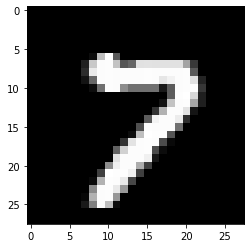

In [218]:
# input-data; X

npimg = X[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0))) # (C,H,W) -> (H,W,C)로 바꿔주는 작업
plt.show()

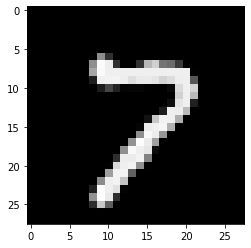

In [219]:
# output-data; X_hat

npimg = X_hat[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

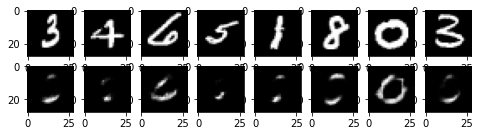

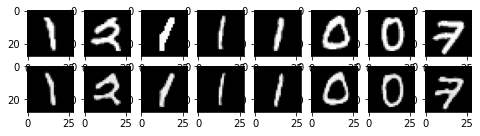

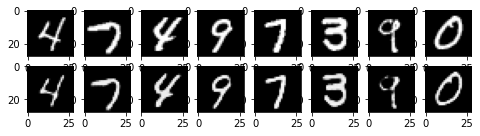

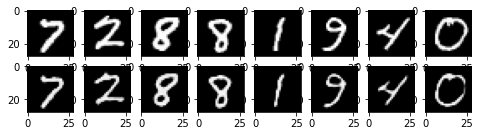

In [220]:
# train데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1) 
        plt.imshow(item[0])

In [223]:
# 모델 평가; test데이터 이용

correct = 0
output_list = []

with torch.no_grad(): # grad가 필요없다.
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        X = images
        outputs = model_Conv(X) # y_pred = f(X)
        X_hat = outputs

        output_list.append((epoch, X, X_hat))

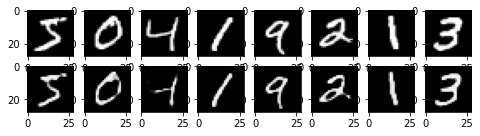

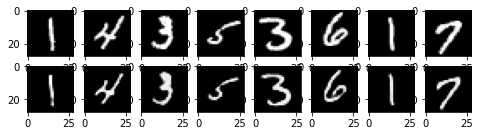

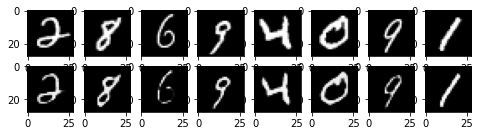

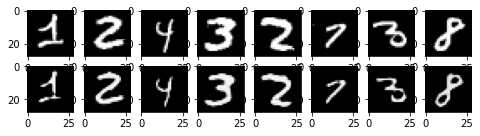

In [224]:
# test데이터에 대한 모델 학습 결과 확인; 시각화

for k in range(0, num_epochs):

    plt.figure(figsize=(9, 2*num_epochs))
    plt.gray()

    imgs = output_list[k][1].detach().to('cpu').numpy()
    recon = output_list[k][2].detach().to('cpu').numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2*num_epochs, 9, 9+i+1)
        plt.imshow(item[0])

## Encoder를 떼어서 차원축소로 활용
* manifold-learning
* 위에서 학습한 모델인 'AE_Conv(Convolution-layer만을 이용한 A.E.)' 사용

In [353]:
temp_model = model_Conv
temp_model

AE_Conv(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

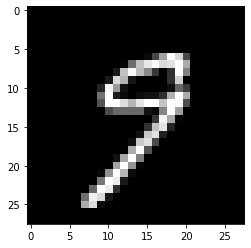

In [354]:
# input-data; images

npimg = X[0].detach().to('cpu').numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))

In [355]:
# output-data; latent-vector

latent_vector = temp_model.encoder(X[0]).flatten().detach().to('cpu').numpy()
latent_vector.shape

(64,)

## Decoder를 떼어서 생성모델로 활용
* Generative_Model
* 위에서 학습한 모델인 'AE_Conv(Convolution-layer만을 이용한 A.E.)' 사용

In [356]:
# 학습이 완료된 모델

train_model = model_Conv
train_model

AE_Conv(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [357]:
# 비교를 위한 학습이 완료되지 않은 모델

# 모델 객체 선언
no_train_model = AE_Conv().to(device) # gpu에 모델 업로드
no_train_model

AE_Conv(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

3개의 latent-vector를 가지고 이미지를 Generate해보자.
* (1) 위에서 압축한 latent-vector을 사용해 이미지 Generate
* (2) 0~1의 uniform-Dist에서 뽑은 임의의 latent-vector
* (3) Normal(0.5, 0.5^2)의 Normal-Dist에서 뽑은 임의의 latent-vector

In [358]:
# input-data; latent-vector

latent_vector_list = []

# (1) 위에서 압축한 latent-vector
latent_vector_list.append(latent_vector)

# (2) 0~1의 uniform-Dist에서 뽑은 임의의 latent-vector
uni_vector = np.random.uniform(0,1,64)
latent_vector_list.append(uni_vector)

# (3) Normal(0.5, 0.5^2)의 Normal-Dist에서 뽑은 임의의 latent-vector
norm_vector = np.random.normal(0.5,0.5, 64)
latent_vector_list.append(norm_vector)

train_model(위에서 학습시킨 A.E.의 Decoder)와 no_train_model(학습되지 않고 구조만 같은 Decoder)를 사용해 이미지를 생성한 결과를 비교해보자.

In [363]:
# output-data; images

def output_visualize():

    model_list = [train_model, no_train_model]

    plt.figure(figsize=(24, 16)) 

    for j in range(len(latent_vector_list)):
        for i in range(len(model_list)):
            temp = torch.tensor(latent_vector_list[j], dtype=torch.float).reshape(64,1,1).to(device)
            output_data = model_list[i].decoder(temp)
            
            npimg = output_data.detach().to('cpu').numpy()

            plt.subplot(3,2,j*2+i+1)
            plt.imshow(np.transpose(npimg, (1,2,0)))
        
    plt.show()

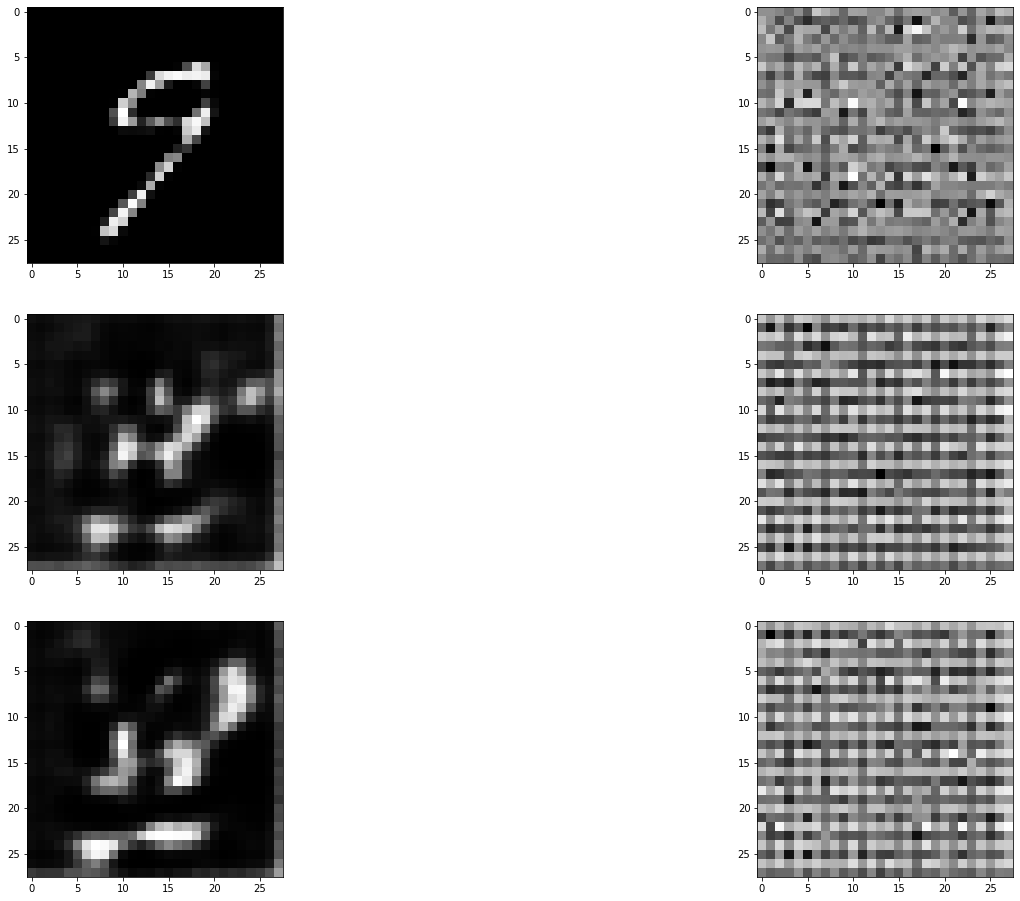

In [364]:
output_visualize(latent_vector)

# 확실히, 동일한 구조의 Decoder라도 학습된 모델이 더 잘 생성한다.

(2) 0~1의 uniform-Dist에서 뽑은 임의의 latent-vector

In [322]:
# input-data; latent-vector

latent_vector = np.random.uniform(0,1,64)
latent_vector.shape

(64,)

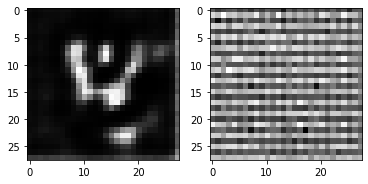

In [323]:
output_visualize()
# 확실히, 동일한 구조의 Decoder라도 학습된 모델이 더 잘 생성한다.